# Analysis of CRDC referral and arrest data 


This notebook contains analysis of data from the US Department of Education Civil Rights Data Collection related to arrests and law enforcement referrals of elementary school children in the US.

## Definitions

All definitions here are from the [Master List of Definitions for the 2015-2016 CRDC](https://ocrdata.ed.gov/assets/downloads/CRDC-Definitions-2015-16.pdf).

### Referral to law enforcement

> "...an action by which a student is reported to any law enforcement agency or official, including a school police unit, for an incident that occurs on school grounds, during schoolrelated events, or while taking school transportation, regardless of whether official action is taken. Citations, tickets, court referrals, and school-related arrests are considered referrals to law enforcement."

### School-Related Arrest

> "...an arrest of a student for any activity conducted on school grounds, during offcampus school activities (including while taking school transportation), or due to a referral by any school official. All school-related arrests are considered referrals to law enforcement."

### Children with Disabilities (IDEA)
> "...children with intellectual disabilities; hearing impairment, including deafness; speech or language impairment; visual impairment, including blindness; serious emotional disturbance; orthopedic impairment; autism; traumatic brain injury; developmental delay; other health impairment; specific learning disability; deaf-blindness; or multiple disabilities and who, by reason thereof, receive special education and related services under the Individuals with Disabilities Education Act according to an Individualized Education Program, Individual Family Service Plan, or service plan."

### Students With Disabilities (Section 504 Only)
> "...students with a disability, who receive related aids and services solely under Section 504 of the Rehabilitation Act of 1973, as amended, and not under the Individuals with Disabilities Education Act (IDEA). The "Section 504 Only" column in the survey items always refers to students with disabilities who receive related aids and services under Section 504 of the Rehabilitation Act of 1973, as amended, and not under IDEA."

In [1]:
import re
import geopandas as gpd
import numpy as np
import pandas as pd


In [2]:
read_df = (
    lambda filename: pd.read_csv(filename, low_memory=False, encoding="latin")
    .rename(columns=lambda col: col.lower())
    .replace(
        {
            -3: np.NaN,
            -5: np.NaN,
            -6: np.NaN,
            -8: np.NaN,
            -9: np.NaN,
            -11: np.NaN,
        }
    )
)

enr = read_df("input/1718-crdc-sch-enrollment.csv")
arr = read_df("input/1718-crdc-sch-referrals-arrests.csv")
cha = read_df("input/1718-crdc-sch-characteristics.csv")


## Overall rates

This analysis is limited to the following criteria:
1. students grades 5 or younger
2. non-juvenile justice facilities
3. non-alternative schools

It will provide referral and arrest rates per 10,000 children

In [3]:
MAX_GRADE = 5
JOIN_ARGS = {"how": "left"}
INDEX_COLS = [
    "combokey",
    "sch_name",
    "lea_name",
    "lea_state_name",
    "jj",
]
MULT = 10_000

sum_sch = lambda df, kwd, colname: (
    df.set_index(INDEX_COLS)[[c for c in df if "tot_" in c and kwd in c]]
    .sum(axis=1)
    .to_frame(colname)
)


def get_max_grade(row):
    true_cols = [
        (k, v) for k, v in row.iteritems() if k.startswith("sch_grade_g") and v == "Yes"
    ]
    if len(true_cols) == 0:
        return np.NaN
    return int(re.search(r"(?<=sch_grade_g)\d{1,2}$", true_cols[-1][0]).group())


cha = cha.set_index(INDEX_COLS).assign(
    max_grade=lambda df: df.apply(get_max_grade, axis=1)
)[["sch_status_alt", "max_grade"]]


assign_rates = lambda df: (
    df.assign(arrest_rate=lambda df: df.arrests / df.enrollment * MULT).assign(
        referral_rate=lambda df: df.referrals / df.enrollment * MULT
    )
)

tot_df_query = lambda max_grade: f"max_grade <= @MAX_GRADE & index.get_level_values('jj') == 'No' & sch_status_alt == 'No'"

tot_df = (
    sum_sch(enr, "enr", "enrollment")
    .join(cha, **JOIN_ARGS)
    .join(sum_sch(arr, "arr", "arrests"), **JOIN_ARGS)
    .join(sum_sch(arr, "ref", "referrals"), **JOIN_ARGS)
    .query(
        "max_grade <= @MAX_GRADE & index.get_level_values('jj') == 'No' & sch_status_alt == 'No'"
    )
    .pipe(assign_rates)
)


### National

Nationwide, there are about 5 referrals and 1 arrest for every 10,000 children enrolled in elementary schools.

In [4]:
national_rates = (
    tot_df[["enrollment", "referrals", "arrests"]]
    .sum()
    .to_frame("United States")
    .transpose()
    .pipe(assign_rates)
    .iloc[0]
)

national_rates.to_frame("United States").round(2)


,United States
enrollment,24684657.00
referrals,12898.00
arrests,2610.00
arrest_rate,1.06
referral_rate,5.23


### By state

The rates of referrals and arrests aren't consistent across states. Some states have rates many times the national average.

In [5]:
state_rates = (
    tot_df.reset_index()
    .groupby("lea_state_name")[["enrollment", "arrests", "referrals"]]
    .sum()
    .pipe(assign_rates)
    .sort_values(["referral_rate", "arrest_rate"], ascending=False)
)

state_rates


,enrollment,arrests,referrals,arrest_rate,referral_rate
lea_state_name,,,,,
VIRGINIA,696651.0,211.0,1843.0,3.028776,26.455140
PENNSYLVANIA,627037.0,44.0,972.0,0.701713,15.501478
NEW HAMPSHIRE,82013.0,25.0,126.0,3.048297,15.363418
ARIZONA,239521.0,44.0,328.0,1.837000,13.693998
MISSOURI,409416.0,225.0,557.0,5.495633,13.604744
WASHINGTON,579119.0,567.0,627.0,9.790734,10.826790
DELAWARE,78946.0,0.0,79.0,0.000000,10.006840
WISCONSIN,412271.0,33.0,377.0,0.800444,9.144471
FLORIDA,1641254.0,35.0,1306.0,0.213252,7.957330


### Individual schools

I'm using some additional criteria to identify problematic schools:
1. At least 100 students enrolled
2. Referral rate at least 5 times the national average
3. Arrest rate at least double the national average

This leaves us with a list of between 100 and 200 schools to focus on

In [6]:
REFERRAL_RATE_THRESHOLD = national_rates.referral_rate * 3
ARREST_RATE_THRESHOLD = national_rates.arrest_rate * 2

problem_schools = (
    tot_df.pipe(assign_rates)
    .query(
        "enrollment >= 100 "
        "& referral_rate >= @REFERRAL_RATE_THRESHOLD"
        "& arrest_rate >= @ARREST_RATE_THRESHOLD"
    )
    .sort_values("referral_rate", ascending=False)
    # geocode schools using NCES school locations file
    # https://nces.ed.gov/programs/edge/geographic/schoollocations
    .pipe(
        lambda df: gpd.read_file("input/EDGE_GEOCODE_PUBLICSCH_1718")
        .to_crs("EPSG:4326")
        .merge(
            df.reset_index(), how="right", left_on=["NCESSCH"], right_on=["combokey"]
        )
    )
    # join nielsen DMAs so I know which to send to which local station
    .pipe(
        lambda df: gpd.sjoin(
            gpd.read_file("input/nielsen-dmas.geojson")[
                ["nielsen_dma", "geometry"]
            ].drop_duplicates(),
            df,
            how="right",
            predicate="contains",
        )
    )[
        INDEX_COLS[:-1]
        + [
            "nielsen_dma",
            "max_grade",
            "arrests",
            "referrals",
            "arrest_rate",
            "referral_rate",
        ]
    ]
)

problem_schools


,combokey,sch_name,lea_name,lea_state_name,nielsen_dma,max_grade,arrests,referrals,arrest_rate,referral_rate
0,530645002813,Ptarmigan Ridge Elementary School,Orting School District,WASHINGTON,Seattle-Tacoma,5.0,484.0,483.0,4923.702950,4913.530010
1,290462000054,SCOTT ELEM.,BELTON 124,MISSOURI,"Kansas City, MO",4.0,60.0,61.0,1929.260450,1961.414791
2,260769004353,CLK Elementary School,Public Schools of Calumet Laurium & Keweenaw,MICHIGAN,"Marquette, MI",5.0,67.0,67.0,1198.568873,1198.568873
3,530645000952,Orting Primary School,Orting School District,WASHINGTON,Seattle-Tacoma,3.0,82.0,83.0,1127.922971,1141.678129
4,481662001427,SMITH EL,DEL VALLE ISD,TEXAS,"Austin, TX",5.0,177.0,177.0,1109.717868,1109.717868
...,...,...,...,...,...,...,...,...,...,...
305,130255001121,Lawrenceville Elementary School,Gwinnett County,GEORGIA,"Atlanta, GA",5.0,2.0,2.0,16.012810,16.012810
306,484122007337,DELORAS E THOMPSON EL,SPRING ISD,TEXAS,"Houston, TX",5.0,2.0,2.0,15.974441,15.974441
307,403024001666,ROBERTSON ES,TULSA,OKLAHOMA,"Tulsa, OK",5.0,1.0,1.0,15.948963,15.948963
308,480771000073,SMITH ACADEMY,ALDINE ISD,TEXAS,"Houston, TX",4.0,1.0,2.0,7.930214,15.860428


In [7]:
(
    problem_schools.rename(
        # user friendly column names for shared file
        columns={
            "combokey": "School ID",
            "sch_name": "School Name",
            "lea_name": "District Name",
            "lea_state_name": "State",
            "nielsen_dma": "Nielsen DMA",
            "max_grade": "Maximum grade",
            "arrests": "Total Arrests",
            "referrals": "Total Referrals",
            "arrest_rate": f"Arrest Rate (per {MULT:,} students)",
            "referral_rate": f"Referral Rate (per {MULT:,} students)",
        }
    ).to_excel(
        f"output/high arrest rate schools, grade {MAX_GRADE} and below.xlsx",
        index=False,
    )
)


## By race

In [8]:
RACE_VALUES = {
    "am": "American Indian/Alaska Native",
    "as": "Asian",
    "bl": "Black",
    "wh": "White",
    "hi": "Hispanic",
    "hp": "Native Hawaiian/Pacific Islander",
    "tr": "Two or More Races",
}
JOIN_ARGS = {"how": "left"}


def split_index(df):
    df.index = df.index.str.split("_")
    return df


def add_col_level(df, col):
    df = df.copy()
    df.columns = pd.MultiIndex.from_tuples((col, c) for c in df)
    return df


ref_arr = lambda kwd, colname: (
    arr.set_index(INDEX_COLS)[
        [
            c
            for c in arr
            if re.search(rf"sch_discwo?dis_{kwd}_(?!504|lep)(idea)?", c) is not None
        ]
    ]
    .rename(columns=lambda c: c.replace("_idea_", "_"))
    .rename(columns=lambda c: re.sub(rf"sch_discwo?dis_{kwd}_", "", c)[:-2])
    .groupby(lambda x: x, axis=1)
    .sum()
    .rename(columns=RACE_VALUES)
    .assign(total=lambda df: df.sum(axis=1))
    .drop("total", axis=1)
    .pipe(add_col_level, colname)
)

select_schools_multiindex = lambda df: df[
    (df.index.get_level_values("jj") == "No")
    & (df[("characteristics", "sch_status_alt")] == "No")
    & (df[("characteristics", "max_grade")] <= MAX_GRADE)
]


race_df = (
    enr.set_index(INDEX_COLS)[
        [
            c
            for c in enr
            if c.startswith("sch_enr")
            and "idea" not in c
            and "504" not in c
            and "lep" not in c
        ]
    ]
    .rename(columns=lambda c: c.replace("sch_enr_", "")[:-2])
    .groupby(lambda x: x, axis=1)
    .sum()
    .rename(columns=RACE_VALUES)
    .pipe(add_col_level, "enrollment")
    .join(ref_arr("arr", "arrests"), **JOIN_ARGS)
    .join(ref_arr("ref", "referrals"), **JOIN_ARGS)
    .join(cha.pipe(add_col_level, "characteristics"), **JOIN_ARGS)
    .fillna(0)
    .pipe(select_schools_multiindex)
)

race_df.head()


enrollment  \
                                                                                    American Indian/Alaska Native   
combokey     sch_name                            lea_name         lea_state_name jj                                 
010000500889 Albertville Elementary School       Albertville City ALABAMA        No                           5.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No                           0.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No                           5.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No                           1.0   
010000600877 Douglas Elementary School           Marshall County  ALABAMA        No                           0.0   

                                                                                           \
                                                                                    Asian   
combokey     sch_name                            lea_name         lea_state_name jj         
010000500889 Albertville Elementary School       Albertville City ALABAMA        No   2.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No   3.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No   3.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No   2.0   
010000600877 Douglas Elementary School           Marshall County  ALABAMA        No   1.0   

                                                                                           \
                                                                                    Black   
combokey     sch_name                            lea_name         lea_state_name jj         
010000500889 Albertville Elementary School       Albertville City ALABAMA        No  35.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No  16.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No  43.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No   2.0   
010000600877 Douglas Elementary School           Marshall County  ALABAMA        No   5.0   

                                                                                              \
                                                                                    Hispanic   
combokey     sch_name                            lea_name         lea_state_name jj            
010000500889 Albertville Elementary School       Albertville City ALABAMA        No    443.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No    223.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No    582.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No     14.0   
010000600877 Douglas Elementary School           Marshall County  ALABAMA        No    205.0   

                                                                                                                      \
                                                                                    Native Hawaiian/Pacific Islander   
combokey     sch_name                            lea_name         lea_state_name jj                                    
010000500889 Albertville Elementary School       Albertville City ALABAMA        No                              2.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No                              1.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No                              3.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No                              0.0   
010000600877 Douglas Elementary School           Marshall County  A

### National

In [9]:
assign_rates_multiindex = lambda df: df.pipe(
    lambda df: df.join(
        (df.arrests / df.enrollment * MULT).pipe(add_col_level, "arrest_rate")
    ).join((df.referrals / df.enrollment * MULT).pipe(add_col_level, "referral_rate"))
)

race_national = (
    race_df.sum(axis=0)
    .to_frame("United States")
    .transpose()
    .sort_index(axis=1)
    .drop("characteristics", axis=1)
    .pipe(assign_rates_multiindex)
)

race_national


arrests                        \
              American Indian/Alaska Native Asian  Black Hispanic   
United States                          18.0  21.0  660.0    911.0   

                                                                         \
              Native Hawaiian/Pacific Islander Two or More Races  White   
United States                              2.0             120.0  889.0   

                                 enrollment                       ...  \
              American Indian/Alaska Native     Asian      Black  ...   
United States                      146227.0  872627.0  2655776.0  ...   

                                   arrest_rate                              \
              Native Hawaiian/Pacific Islander Two or More Races     White   
United States                         0.375834          1.551657  1.103265   

                              referral_rate                                 \
              American Indian/Alaska Native     Asian      Black  Hispanic   
United States                     16.617998  3.838983  15.246015  6.376298   

                                                                            
              Native Hawaiian/Pacific Islander Two or More Races     White  
United States                         2.630837         10.370238  5.559758  

[1 rows x 35 columns]

#### Arrest and referral rates 

array([<AxesSubplot:title={'center':'arrest_rate'}>,
       <AxesSubplot:title={'center':'referral_rate'}>], dtype=object)

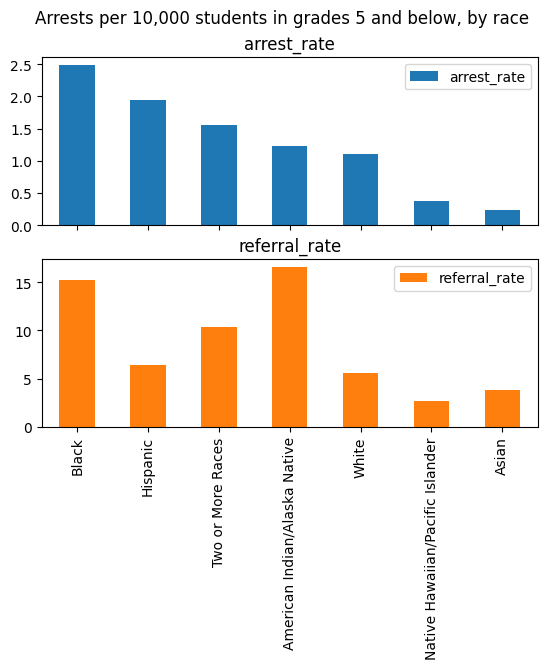

In [10]:
(
    race_national[["referral_rate", "arrest_rate"]]
    .transpose()
    .unstack(0)
    .droplevel(0, axis=1)
    .sort_values("arrest_rate", ascending=False)
    .sort_index(axis=1)
    .plot(
        kind="bar",
        title=f"Arrests per 10,000 students in grades {MAX_GRADE} and below, by race",
        subplots=True,
    )
)


#### Non-white students compared to White students

array([<AxesSubplot:title={'center':'arrest_rate'}>,
       <AxesSubplot:title={'center':'referral_rate'}>], dtype=object)

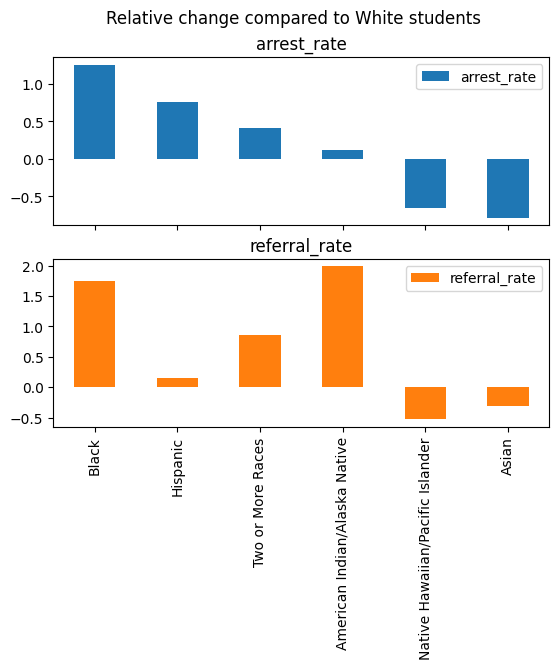

In [11]:
def compare_white(df):
    df = df.copy()
    for col in df:
        if col == "White":
            continue
        df[col] = (df[col] - df["White"]) / df["White"]

    del df["White"]
    return df


(
    race_national.arrest_rate.pipe(compare_white)
    .transpose()
    .rename(columns={"United States": "arrest_rate"})
    .join(
        race_national.referral_rate.pipe(compare_white)
        .transpose()
        .rename(columns={"United States": "referral_rate"})
    )
    .sort_values("arrest_rate", ascending=False)
    .plot(kind="bar", title="Relative change compared to White students", subplots=True)
)


### By state

In [12]:
race_state = (
    race_df.enrollment.reset_index()
    .groupby(["lea_state_name"])
    .sum()
    .pipe(add_col_level, "enrollment")
    .join(
        race_df.arrests.reset_index()
        .groupby(["lea_state_name"])
        .sum()
        .pipe(add_col_level, "arrests")
    )
    .join(
        race_df.referrals.reset_index()
        .groupby(["lea_state_name"])
        .sum()
        .pipe(add_col_level, "referrals")
    )
    .pipe(assign_rates_multiindex)
)

race_state.head()


enrollment                               \
               American Indian/Alaska Native     Asian    Black  Hispanic   
lea_state_name                                                              
ALABAMA                               1778.0    4075.0  89116.0   23068.0   
ALASKA                                4497.0    1476.0    565.0    1263.0   
ARIZONA                              12349.0    5473.0   9436.0   87225.0   
ARKANSAS                              1105.0    2890.0  37369.0   25345.0   
CALIFORNIA                            6572.0  165177.0  81987.0  796629.0   

                                                                             \
               Native Hawaiian/Pacific Islander Two or More Races     White   
lea_state_name                                                                
ALABAMA                                   354.0            6182.0  122056.0   
ALASKA                                    859.0            2906.0   11050.0   
ARIZONA                                   674.0            6321.0   55666.0   
ARKANSAS                                 2107.0            5084.0   99246.0   
CALIFORNIA                               7261.0           74476.0  348911.0   

                                     arrests              ...  \
               American Indian/Alaska Native Asian Black  ...   
lea_state_name                                            ...   
ALABAMA                                  0.0   0.0   4.0  ...   
ALASKA                                   0.0   0.0   0.0  ...   
ARIZONA                                  5.0   1.0   3.0  ...   
ARKANSAS                                 1.0   0.0   1.0  ...   
CALIFORNIA                               0.0   3.0   2.0  ...   

                                    arrest_rate                              \
               Native Hawaiian/Pacific Islander Two or More Races     White   
lea_state_name                                                                
ALABAMA                                     0.0          0.000000  0.081930   
ALASKA                                      0.0          0.000000  0.000000   
ARIZONA                                     0.0         11.074197  2.335357   
ARKANSAS                                    0.0          0.000000  0.100760   
CALIFORNIA                                  0.0          0.134271  0.257945   

                               referral_rate                                   \
               American Indian/Alaska Native      Asian      Black   Hispanic   
lea_state_name                                                                  
ALABAMA                             0.000000   0.000000   2.356479   0.433501   
ALASKA                             20.013342   0.000000   0.000000   7.917656   
ARIZONA                           108.510811   5.481454  25.434506  11.349957   
ARKANSAS                           18.099548   0.000000   4.014022   1.972776   
CALIFORNIA                         10.651248  14.348245  40.006342   7.720030   

                                                                              
               Native Hawaiian/Pacific Islander Two or More Races      White  
lea_state_name                                                                
ALABAMA                                0.000000          0.000000   1.392803  
ALASKA                                 0.000000         13.764625   2.714932  
ARIZONA                               14.836795         15.820282  10.239644  
ARKANSAS                               0.000000          0.000000   3.022792  
CALIFORNIA                             1.377221         23.094688  11.378260  

[5 rows x 35 columns]

In [13]:
race_white_compare_state = (
    compare_white(race_state.arrest_rate)
    .pipe(add_col_level, "arrest_rate")
    .join(compare_white(race_state.referral_rate).pipe(add_col_level, "referral_rate"))
)

race_white_compare_state.head()


arrest_rate                                \
               American Indian/Alaska Native     Asian     Black  Hispanic   
lea_state_name                                                               
ALABAMA                            -1.000000 -1.000000  4.478522 -1.000000   
ALASKA                                   NaN       NaN       NaN       NaN   
ARIZONA                             0.733744 -0.217614  0.361382 -0.263629   
ARKANSAS                           88.815385 -1.000000  1.655838 -1.000000   
CALIFORNIA                         -1.000000 -0.295885 -0.054292 -0.124031   

                                                                   \
               Native Hawaiian/Pacific Islander Two or More Races   
lea_state_name                                                      
ALABAMA                                    -1.0         -1.000000   
ALASKA                                      NaN               NaN   
ARIZONA                                    -1.0          3.741971   
ARKANSAS                                   -1.0         -1.000000   
CALIFORNIA                                 -1.0         -0.479458   

                               referral_rate                                \
               American Indian/Alaska Native     Asian     Black  Hispanic   
lea_state_name                                                               
ALABAMA                            -1.000000 -1.000000  0.691897 -0.688757   
ALASKA                              6.371581 -1.000000 -1.000000  1.916337   
ARIZONA                             9.597128 -0.464683  1.483925  0.108433   
ARKANSAS                            4.987692 -1.000000  0.327919 -0.347366   
CALIFORNIA                         -0.063895  0.261023  2.516033 -0.321510   

                                                                   
               Native Hawaiian/Pacific Islander Two or More Races  
lea_state_name                                                     
ALABAMA                               -1.000000         -1.000000  
ALASKA                                -1.000000          4.069970  
ARIZONA                                0.448956          0.545003  
ARKANSAS                              -1.000000         -1.000000  
CALIFORNIA                            -0.878960          1.029721

array([<AxesSubplot:title={'center':'(arrest_rate, American Indian/Alaska Native)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'center':'(arrest_rate, Asian)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'center':'(arrest_rate, Black)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'center':'(arrest_rate, Hispanic)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'center':'(arrest_rate, Native Hawaiian/Pacific Islander)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'center':'(arrest_rate, Two or More Races)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'center':'(referral_rate, American Indian/Alaska Native)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'center':'(referral_rate, Asian)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'center':'(referral_rate, Black)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'center':'(referral_rate, Hispanic)'}, ylabel='lea_state_name'>,
       <AxesSubplot:title={'c

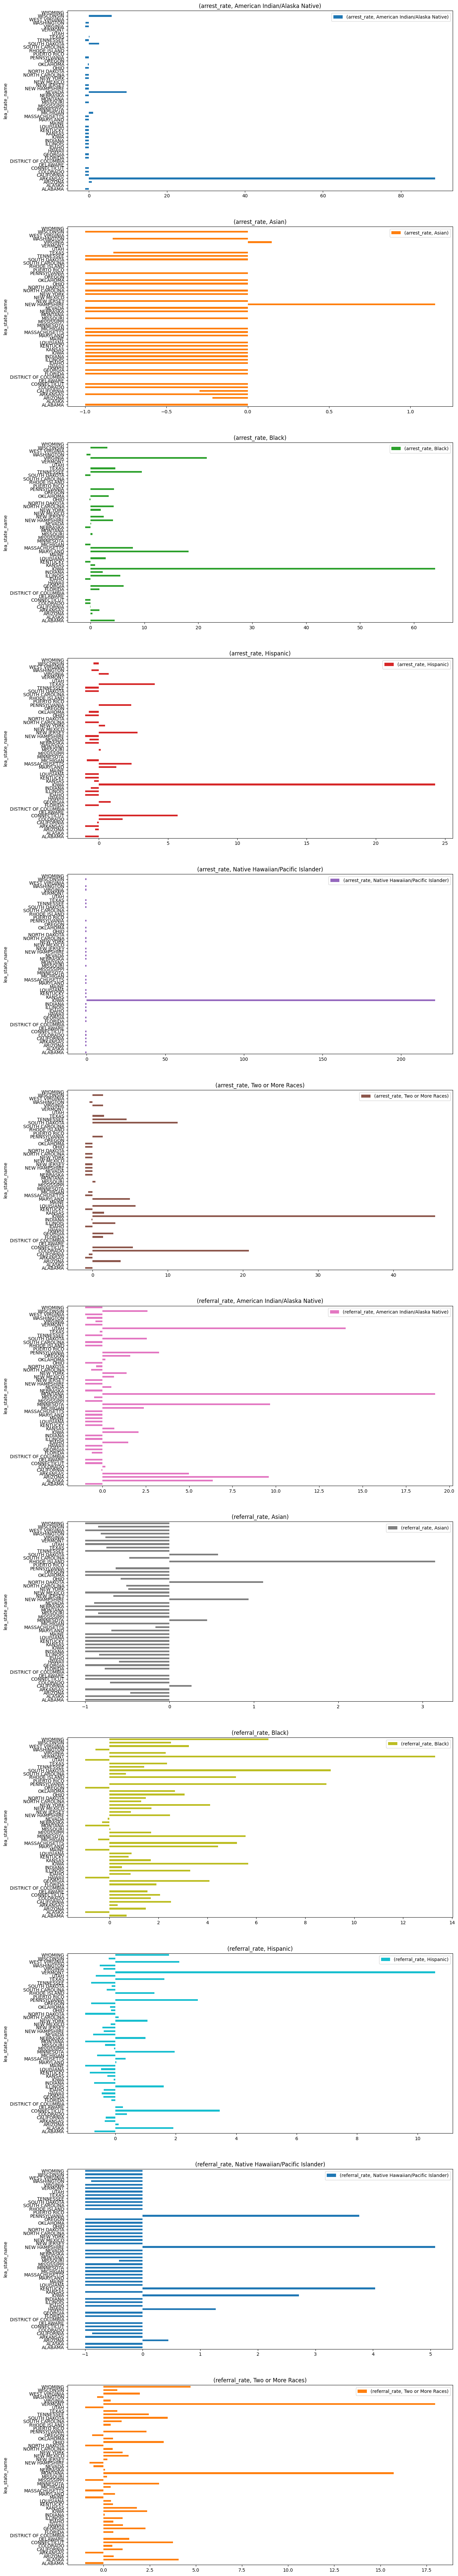

In [14]:
(
    race_white_compare_state.plot(
        kind="barh",
        subplots=True,
        figsize=(15, 100),
        sharex=False,
    )
)


## By disability status

In [15]:
sum_cols = lambda df, kwd, colname: (
    df[[c for c in df.columns if kwd in c]].sum(axis=1).to_frame(colname)
)

dis_df = (
    enr.set_index(INDEX_COLS)
    .pipe(
        lambda df: sum_cols(df, "tot_enr", "total")
        .join(sum_cols(df, "tot_ideaenr", "idea"), **JOIN_ARGS)
        .join(sum_cols(df, "tot_504enr", "section_504"), **JOIN_ARGS)
    )
    .assign(without_disabilities=lambda df: df.total - (df.idea + df["section_504"]))
    .drop("total", axis=1)
    .sort_index(axis=1)
    .pipe(add_col_level, "enrollment")
    .join(
        arr.set_index(INDEX_COLS)
        .pipe(
            lambda df: sum_cols(df, "tot_discwodis_ref", "without_disabilities")
            .join(sum_cols(df, "tot_discwdis_ref_idea", "idea"), **JOIN_ARGS)
            .join(sum_cols(df, "tot_discwdis_ref_504", "section_504"), **JOIN_ARGS)
        )
        .pipe(add_col_level, "referrals"),
        **JOIN_ARGS
    )
    .join(
        arr.set_index(INDEX_COLS)
        .pipe(
            lambda df: sum_cols(df, "tot_discwodis_arr", "without_disabilities")
            .join(sum_cols(df, "tot_discwdis_arr_idea", "idea"), **JOIN_ARGS)
            .join(sum_cols(df, "tot_discwdis_arr_504", "section_504"), **JOIN_ARGS)
        )
        .pipe(add_col_level, "arrests"),
        **JOIN_ARGS
    )
    .join(cha.pipe(add_col_level, "characteristics"), **JOIN_ARGS)
    .pipe(select_schools_multiindex)
)

dis_df.head()


enrollment  \
                                                                                          idea   
combokey     sch_name                            lea_name         lea_state_name jj              
010000500889 Albertville Elementary School       Albertville City ALABAMA        No       78.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No      183.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No       42.0   
010000600877 Douglas Elementary School           Marshall County  ALABAMA        No       64.0   
010000600880 Brindlee Mountain Elementary School Marshall County  ALABAMA        No       45.0   

                                                                                                 \
                                                                                    section_504   
combokey     sch_name                            lea_name         lea_state_name jj               
010000500889 Albertville Elementary School       Albertville City ALABAMA        No         0.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No         0.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No         0.0   
010000600877 Douglas Elementary School           Marshall County  ALABAMA        No         1.0   
010000600880 Brindlee Mountain Elementary School Marshall County  ALABAMA        No         0.0   

                                                                                                          \
                                                                                    without_disabilities   
combokey     sch_name                            lea_name         lea_state_name jj                        
010000500889 Albertville Elementary School       Albertville City ALABAMA        No                828.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No                831.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No                 95.0   
010000600877 Douglas Elementary School           Marshall County  ALABAMA        No                443.0   
010000600880 Brindlee Mountain Elementary School Marshall County  ALABAMA        No                183.0   

                                                                                               referrals  \
                                                                                    without_disabilities   
combokey     sch_name                            lea_name         lea_state_name jj                        
010000500889 Albertville Elementary School       Albertville City ALABAMA        No                  0.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No                  0.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No                  0.0   
010000600877 Douglas Elementary School           Marshall County  ALABAMA        No                  0.0   
010000600880 Brindlee Mountain Elementary School Marshall County  ALABAMA        No                  0.0   

                                                                                          \
                                                                                    idea   
combokey     sch_name                            lea_name         lea_state_name jj        
010000500889 Albertville Elementary School       Albertville City ALABAMA        No  0.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No  0.0   
010000600876 Claysville School                   Marshall County  ALABAMA        No  0.0   
010000600877 Douglas Elementary School           Marshall County  ALABAMA        No  0.0   
010000600880 Brindlee Mountain Elementary School Marshall County  ALABAMA        No  0.0   

                                       

### National

In [16]:
dis_national = (
    dis_df[["enrollment", "referrals", "arrests"]]
    .sum()
    .to_frame("United States")
    .transpose()
    .pipe(assign_rates_multiindex)
)

dis_national


enrollment                                   \
                    idea section_504 without_disabilities   
United States  2202500.0    328067.0           14282527.0   

                         referrals                                  arrests  \
              without_disabilities    idea section_504 without_disabilities   
United States               8546.0  4352.0         0.0               1854.0   

                                 arrest_rate                                   \
                idea section_504        idea section_504 without_disabilities   
United States  756.0         0.0    3.432463         0.0              1.29809   

              referral_rate                                   
                       idea section_504 without_disabilities  
United States     19.759364         0.0             5.983535

array([<AxesSubplot:title={'center':'arrest_rate'}>,
       <AxesSubplot:title={'center':'referral_rate'}>], dtype=object)

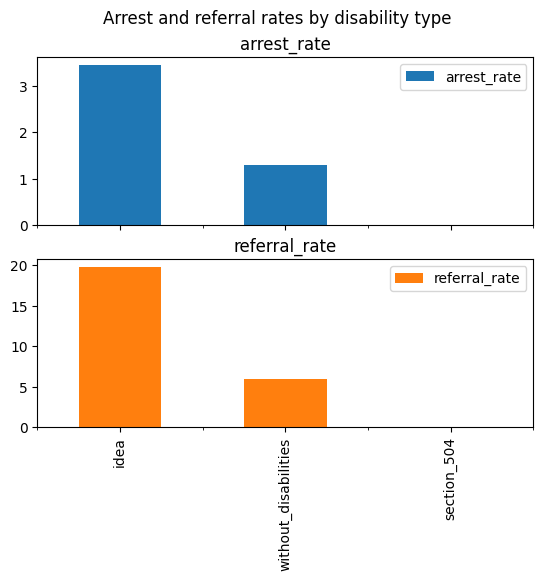

In [17]:
(
    dis_national[["arrest_rate", "referral_rate"]]
    .transpose()
    .unstack(0)
    .droplevel(0, axis=1)
    .sort_values("arrest_rate", ascending=False)
    .plot(
        kind="bar", subplots=True, title="Arrest and referral rates by disability type"
    )
)


### By state

In [18]:
dis_state = (
    dis_df.enrollment.reset_index()
    .groupby("lea_state_name")
    .sum()
    .pipe(add_col_level, "enrollment")
    .join(
        dis_df.referrals.reset_index()
        .groupby("lea_state_name")
        .sum()
        .pipe(add_col_level, "referrals"),
        **JOIN_ARGS
    )
    .join(
        dis_df.arrests.reset_index()
        .groupby("lea_state_name")
        .sum()
        .pipe(add_col_level, "arrests"),
        **JOIN_ARGS
    )
    .pipe(assign_rates_multiindex)
)

dis_state.head()


enrollment                                   \
                     idea section_504 without_disabilities   
lea_state_name                                               
ALABAMA           33772.0      2764.0             206525.0   
ALASKA             3834.0       220.0              18562.0   
ARIZONA           21586.0      1344.0             150933.0   
ARKANSAS          20611.0      4806.0             143690.0   
CALIFORNIA       162705.0      9563.0            1276511.0   

                          referrals                                 arrests  \
               without_disabilities   idea section_504 without_disabilities   
lea_state_name                                                                
ALABAMA                        27.0   12.0         0.0                  3.0   
ALASKA                          7.0   10.0         0.0                  0.0   
ARIZONA                       262.0   66.0         0.0                 27.0   
ARKANSAS                       38.0   14.0         0.0                  2.0   
CALIFORNIA                   1399.0  358.0         0.0                 28.0   

                                 arrest_rate                                   \
                idea section_504        idea section_504 without_disabilities   
lea_state_name                                                                  
ALABAMA          2.0         0.0    0.592207         0.0             0.145261   
ALASKA           0.0         0.0    0.000000         0.0             0.000000   
ARIZONA         17.0         0.0    7.875475         0.0             1.788873   
ARKANSAS         1.0         0.0    0.485178         0.0             0.139189   
CALIFORNIA       5.0         0.0    0.307305         0.0             0.219348   

               referral_rate                                   
                        idea section_504 without_disabilities  
lea_state_name                                                 
ALABAMA             3.553239         0.0             1.307348  
ALASKA             26.082420         0.0             3.771145  
ARIZONA            30.575373         0.0            17.358696  
ARKANSAS            6.792489         0.0             2.644582  
CALIFORNIA         22.003012         0.0            10.959561

In [19]:
idea_vs_nondis = (
    lambda df: (df.idea - df.without_disabilities) / df.without_disabilities
)

dis_state_compare_df = (
    dis_state.arrest_rate.pipe(idea_vs_nondis)
    .to_frame("arrest_rate")
    .join(dis_state.referral_rate.pipe(idea_vs_nondis).to_frame("referral_rate"))
    .sort_values("arrest_rate", ascending=False)
    .pipe(
        add_col_level,
        f"Relative change, idea vs. non-disabled students grades {MAX_GRADE} and below",
    )
)

dis_state_compare_df


Relative change, idea vs. non-disabled students grades 5 and below  \
                                                                            arrest_rate   
lea_state_name                                                                            
HAWAII                                                              inf                   
NORTH DAKOTA                                                        inf                   
NEW YORK                                                            inf                   
NORTH CAROLINA                                                10.815262                   
IOWA                                                          10.019335                   
SOUTH DAKOTA                                                   6.912793                   
WISCONSIN                                                      6.875583                   
CONNECTICUT                                                    6.660892                   
OHIO                                                           6.609368                   
KANSAS                                                         6.183635                   
TENNESSEE                                                      5.598706                   
PENNSYLVANIA                                                   4.546548                   
COLORADO                                                       3.753768                   
LOUISIANA                                                      3.634003                   
ARIZONA                                                        3.402478                   
KENTUCKY                                                       3.300436                   
INDIANA                                                        3.274706                   
ALABAMA                                                        3.076849                   
TEXAS                                                          2.556913                   
VIRGINIA                                                       2.532235                   
ARKANSAS                                                       2.485760                   
ILLINOIS                                                       2.315483                   
MISSOURI                                                       2.255904                   
MINNESOTA                                                      2.019850                   
MARYLAND                                                       2.012222                   
OKLAHOMA                                                       1.877017                   
NEW JERSEY                                                     1.694904                   
MICHIGAN                                                       1.668734                   
GEORGIA                                                        1.544656                   
WASHINGTON                                                     0.906500                   
NEVADA                                                         0.790262                   
FLORIDA                                                        0.432308                   
CALIFORNIA                                                     0.400992                   
IDAHO                                                         -1.000000                   
NEW HAMPSHIRE                                                 -1.000000                   
SOUTH CAROLINA                                                -1.000000                   
NEBRASKA                                                      -1.000000                   
MONTANA                                                       -1.000000                   
UTAH                                                          -1.000000                   
MASSACHUSETTS                                                 -1.000000                   
ALASKA                                                              NaN                   
DELAWARE         

array([<AxesSubplot:title={'center':'Relative change, idea vs. non-disabled students grades 5 and below'}, xlabel='lea_state_name'>,
       <AxesSubplot:title={'center':'arrest_rate'}, xlabel='lea_state_name'>],
      dtype=object)

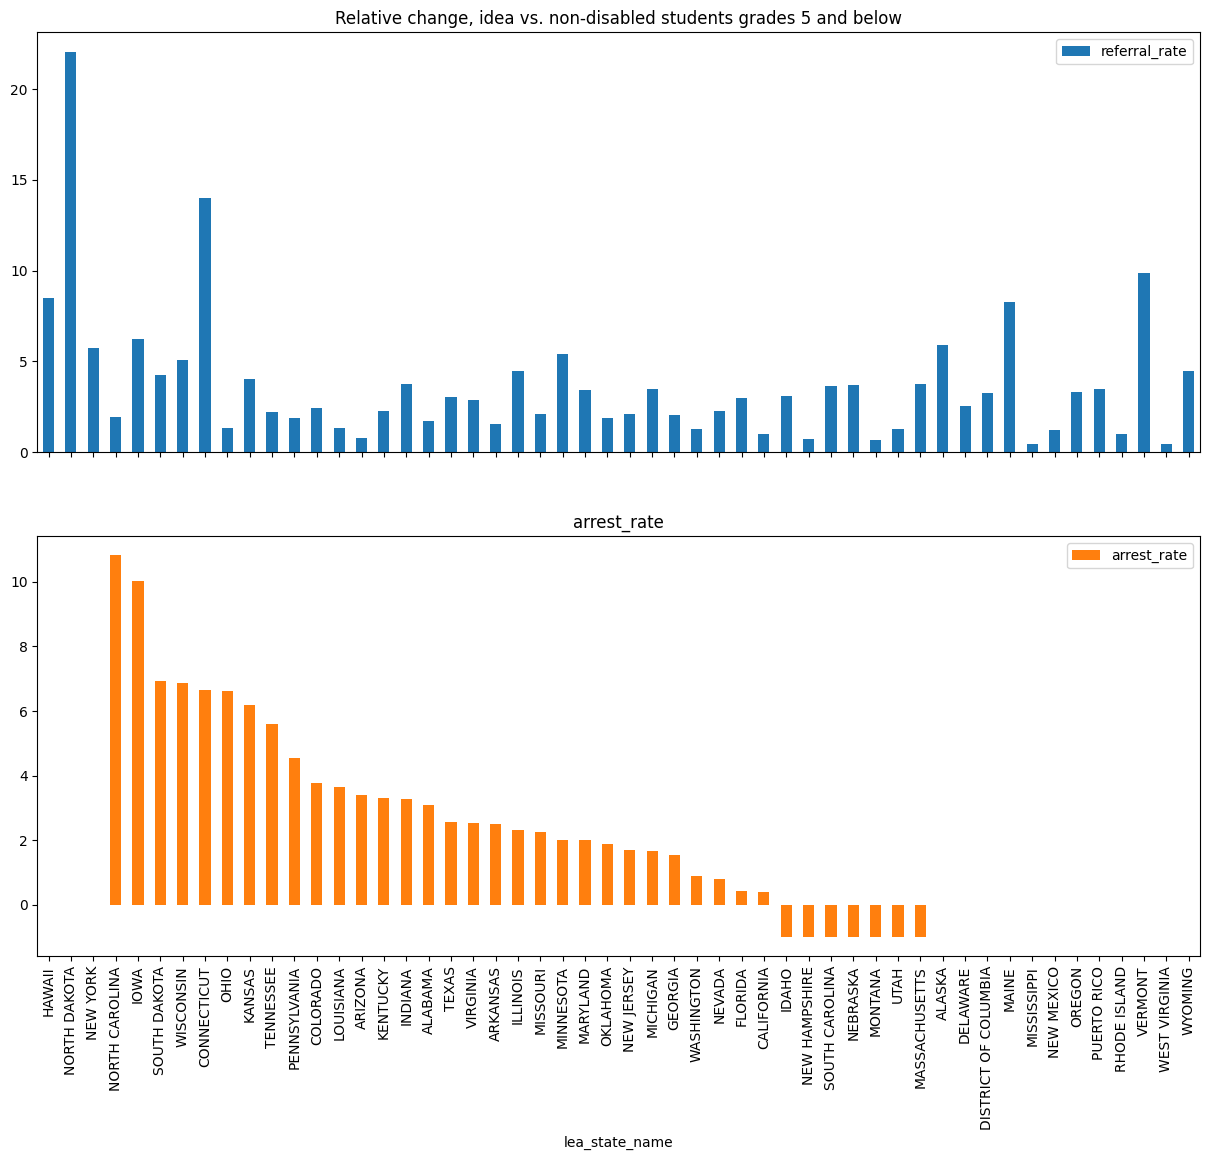

In [20]:
(
    dis_state_compare_df.droplevel(0, axis=1)
    .sort_index(axis=1, ascending=False)
    .plot(
        kind="bar",
        subplots=True,
        figsize=(15, 12),
        title=dis_state_compare_df.columns[0],
    )
)


## Output

In [21]:
state_rates.to_excel(f"output/referrals and arrests, grade {MAX_GRADE} and below.xlsx")
